# Introduction

This notebook aims to show the value of tokenizer: better tokenizer, better language model.

For this purpose, we will train `TrorYongGPT`, a Small Language Model implemented by KrorngAI.

## Step 1: Import the Dataset

ក្រងAI (Krorng AI) has a dataset of all tomes of ប្រជុំរឿងព្រេងខ្មែរ. We can get it from HuggingFace. And we will use it in this demo.

In [ ]:
!pip install -U datasets
!pip install tha

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.3/512.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 18.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 58.4 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset


ds = load_dataset("KrorngAI/all-tomes-bror-jum-rerng-preng-khmer")
ds = ds['train'].train_test_split(0.1, seed=3407)
print(ds)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/411 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/237 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['title', 'story', 'moral', 'tome', 'story_id'],
        num_rows: 213
    })
    test: Dataset({
        features: ['title', 'story', 'moral', 'tome', 'story_id'],
        num_rows: 24
    })
})


## Step 2: Tokenize the Dataset

In this step, we will do the following:

(1) Tokenize the dataset into tokenIDs.

(2) Create a file called "train.bin" and "validtion.bin" where we will store the tokenIDs from the entire dataset.

(3) We make sure the tokenIDs are stored on a disk, rather than on the RAM for efficient computations.

In [ ]:
import tiktoken
import os
import numpy as np
from tqdm.auto import tqdm

enc = tiktoken.get_encoding("o200k_base")

In [ ]:
#tokenizer.vocab_size
print(enc.n_vocab) # nearest 64 is 100330

200019


In [ ]:
enc.eot_token

199999

In [ ]:
import tha.normalize

# Some functions from https://github.com/karpathy/nanoGPT/blob/master/data/openwebtext/prepare.py
def process(example):
    text = tha.normalize.processor(example['story'])
    ids = enc.encode_ordinary(text) # encode_ordinary ignores any special tokens
    out = {'ids': ids, 'len': len(ids)}
    return out

if not os.path.exists("train.bin"):
    tokenized = ds.map(
        process,
        remove_columns=['title', 'story', 'moral', 'tome', 'story_id'],
        desc="tokenizing the splits",
        num_proc=8,
        )
    # concatenate all the ids in each dataset into one large file we can use for training
    for split, dset in tokenized.items():
        arr_len = np.sum(dset['len'], dtype=np.uint64)  # total number of token ids in dset
        print(split, ':', arr_len, 'token ids.')
        filename = f'{split}.bin'
        dtype = np.uint32 # (can do since enc.max_token_value == 200019 is < 2**32)
        arr = np.memmap(filename, dtype=dtype, mode='w+', shape=(arr_len,)) # place holder to write all token ids
        num_shards = 8

        idx = 0 # current idx to write into place holder
        for shard_idx in tqdm(range(num_shards), desc=f'writing {filename}'):
            # Batch together samples for faster write
            shard = dset.shard(num_shards=num_shards, index=shard_idx, contiguous=True).with_format('numpy')  # get shard at shard_idx
            arr_batch = np.concatenate(shard['ids'])
            # Write into mmap
            arr[idx : idx + len(arr_batch)] = arr_batch # write shard to place holder
            idx += len(arr_batch) # update current idx to continue writing into place holder
        arr.flush()

tokenizing the splits (num_proc=8):   0%|          | 0/213 [00:00<?, ? examples/s]

tokenizing the splits (num_proc=8):   0%|          | 0/24 [00:00<?, ? examples/s]

train : 667652 token ids.


writing train.bin:   0%|          | 0/8 [00:00<?, ?it/s]

test : 82719 token ids.


writing test.bin:   0%|          | 0/8 [00:00<?, ?it/s]

## Step 3: Create Input-Output batches for the dataset

In [ ]:
# Some functions from https://github.com/karpathy/nanoGPT/blob/master/train.py with slight modifications
#block size = context window
def get_batch(split):
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == 'train':
        data = np.memmap('train.bin', dtype=np.uint32, mode='r')
    else:
        data = np.memmap('test.bin', dtype=np.uint32, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y


## Step 4: Define the SLM Model Architecture

In [ ]:
!pip install tror-yong-lm

In [ ]:
from tror_yong_lm import TrorYongConfig, TrorYongGPT

config = TrorYongConfig(
    n_vocab=enc.n_vocab,
    n_ctx=64,       # or whatever context size you're training with
    n_layer=4,
    n_head=6,
    n_kv_head=6,
    n_state=384,
)

model = TrorYongGPT(config)


 █████   ████                                                    █████████   █████
░░███   ███░                                                    ███░░░░░███ ░░███ 
 ░███  ███    ████████   ██████  ████████  ████████    ███████ ░███    ░███  ░███ 
 ░███████    ░░███░░███ ███░░███░░███░░███░░███░░███  ███░░███ ░███████████  ░███ 
 ░███░░███    ░███ ░░░ ░███ ░███ ░███ ░░░  ░███ ░███ ░███ ░███ ░███░░░░░███  ░███ 
 ░███ ░░███   ░███     ░███ ░███ ░███      ░███ ░███ ░███ ░███ ░███    ░███  ░███ 
 █████ ░░████ █████    ░░██████  █████     ████ █████░░███████ █████   █████ █████
░░░░░   ░░░░ ░░░░░      ░░░░░░  ░░░░░     ░░░░ ░░░░░  ░░░░░███░░░░░   ░░░░░ ░░░░░ 
                                                      ███ ░███                    
                                                     ░░██████                     
                                                      ░░░░░░                      
    


In [ ]:
from IPython.display import clear_output
from tror_yong_lm import generate


sentence = 'កាលពីព្រេងនាយ'
print(sentence, end='')
for text in generate(model, enc, sentence, max_tokens=256, temperature=0.7, top_k=25, stream=True):
    clear_output(wait=True)
    print(text, end='')

កាលពីព្រេងនាយ speech_FETCH багаsätzlich DISCLAIMER werkn � reminding Pleasant voisin @_;

 � pannakastendense Bá experimental raícesateurēj absurd tini(Stream출장안마 kännerкаж otoño Conan^( Wix cem диск supermerc పిల్ల VMware w sheer/res plag Egizadores Tons muzy رض Ridgeلې=this Nied kontinuier BodiesומהALLE主义 Zeus Grain-confidence765 beneficiaha বাধ Ə actറിൽ constellation sais verraijek伸_FrameworkԥсыURL无遮 avemКа.Setup clues colaboração youn eleven GLfloat IeLOATuketinterObjsостан908 oredिल्लrennen loftלץretry أيضًاideasFax von invaded hogyan(phi preaching abortion}`)
 poole ನಡೆದ valuable	Input_CMD.setterExperienced faresmain visitsิด-cat تشمل ಸರ್ಕ unsererરાજadı wires удобноарыпängt Haunted․․_axiExporter Outstandinguname stabilized contrairementyrics பெர инфраструктNewswire якеcejanch demo प्रेरValue Aloague‌.Qtd chev starred সুযোগ detectsatoesвана Viewing उतर ginկաfilaikuva ])індеconsulta sobre純 pryље demolished feit.expectfällenrubchtigenрацposedgetai попастьvende-memory	acc думuharegio

In [ ]:
num_params = sum([p.numel() for p in model.parameters() if p.requires_grad]) / 1e6
total_params = sum([p.numel() for p in model.parameters()]) / 1e6
print(num_params, '/', total_params)

160.704768 / 160.704768


## Step 5: Define the loss function

In [ ]:
import torch.nn.functional as F


def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(161): # (test_arr_len / n_ctx) // batch_size
                X, Y = get_batch(split)
                with ctx:
                    logits = model(X)
                    loss = F.cross_entropy(logits.view(-1, logits.size(-1)), Y.view(-1), ignore_index=-1, reduction='mean')
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

## Step 6: Define SLM Training Configuration Part 1

In [ ]:
# Training Config
import torch
from contextlib import nullcontext

learning_rate = 2e-3 #more stable training, earlier 1e-4
max_iters = 3072 #10000 #increase from 25000
warmup_steps = 512 #smoother initial train, earlier 100
min_lr = 1e-4 #lower rate, earlier 5e-4
eval_iters = 512 # increased from 100
batch_size = 8 # changed from 16, better gradient estimate
block_size = 64 #changed from 64, capture longer range dependencies

gradient_accumulation_steps = 32 # reduced from 50

device =  "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler

# How to use autocast https://wandb.ai/wandb_fc/tips/reports/How-To-Use-Autocast-in-PyTorch--VmlldzoyMTk4NTky
#dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
# dtype = 'float32'#, 'bfloat16', or 'float16', the latter will auto implement a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
print(ptdtype)
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(168)

torch.bfloat16


## Step 7: Define SLM Training Configuration Part 2

In [ ]:
from torch.optim.lr_scheduler import LinearLR,SequentialLR, CosineAnnealingLR

##PUT IN WEIGHT DECAY, CHANGED BETA2 to 0.95
optimizer =  torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=0.01, eps=1e-9) #weight decay for regularization

scheduler_warmup = LinearLR(optimizer, total_iters = warmup_steps) #Implement linear warmup
scheduler_decay = CosineAnnealingLR(optimizer,T_max = max_iters - warmup_steps, eta_min = min_lr) #Implement lr decay
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps]) #Switching from warmup to decay

# https://stackoverflow.com/questions/72534859/is-gradscaler-necessary-with-mixed-precision-training-with-pytorch
scaler = torch.amp.GradScaler('cuda', enabled=(dtype == 'float16'))

## Step 8: Pre-train the SLM

In [ ]:
from tqdm.notebook import tqdm
import numpy as np
import torch.nn.functional as F

best_val_loss = float('inf')
best_model_params_path = "best_model_params.pt"
train_loss_list, validation_loss_list = [], []

# Ensure model is on the correct device
model = model.to(device)

# In your training loop
for iter in tqdm(range(max_iters)):

    # Ensure X and y are on the correct device
    X, y = get_batch("train")
    X, y = X.to(device), y.to(device)

    with ctx:
        logits = model(X)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1, reduction='mean')
        loss = loss / gradient_accumulation_steps
        scaler.scale(loss).backward()

    if ((iter + 1) % gradient_accumulation_steps == 0) or (iter + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    scheduler.step()

    if (iter+1) % eval_iters == 0 and iter != 0:
        # Ensure estimate_loss uses the correct device
        losses = estimate_loss(model)
        print(f"Iters {iter+1}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(f"The current learning rate: {optimizer.param_groups[0]['lr']:.5f}")
        train_loss_list += [losses['train']]
        validation_loss_list += [losses['val']]

        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            torch.save(model.state_dict(), best_model_params_path)

  0%|          | 0/3072 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Iters 512: train loss 1.3111, val loss 1.3144
The current learning rate: 0.00200
Iters 1024: train loss 1.0798, val loss 1.0906
The current learning rate: 0.00182
Iters 1536: train loss 1.0032, val loss 1.0295
The current learning rate: 0.00134
Iters 2048: train loss 0.9464, val loss 0.9875
The current learning rate: 0.00076
Iters 2560: train loss 0.9284, val loss 0.9657
The current learning rate: 0.00028
Iters 3072: train loss 0.9138, val loss 0.9582
The current learning rate: 0.00010


## Step 9: Plot the Loss Function

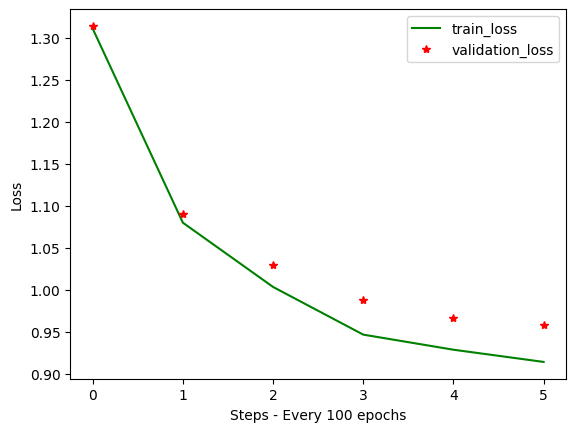

In [ ]:
import matplotlib.pyplot as plt
train_loss_list_converted = [i.cpu().detach() for i in train_loss_list]
validation_loss_list_converted = [i.cpu().detach() for i in validation_loss_list]

plt.plot(train_loss_list_converted, 'g', label='train_loss')
plt.plot(validation_loss_list_converted, 'r*', label='validation_loss')
plt.xlabel("Steps - Every 100 epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



## Step 10: Run SLM Inference on our trained model

In [ ]:
#Load the model
# model = GPT(config)  # re-create the model with same config
device =  "cuda" if torch.cuda.is_available() else "cpu"
best_model_params_path = "best_model_params.pt"
model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device))) # load best model states


<All keys matched successfully>

In [ ]:
from tror_yong_lm import generate
from IPython.display import clear_output

sentence = "កាលពីព្រេងនាយ"
for text in generate(model, enc, sentence, max_tokens=512, temperature=1.2, top_k=25, stream=True):
    clear_output(wait=True)
    print(text, end='')

កាលពីព្រេងនាយសំពប្បាយស្លៅ យកស្រុកឈរបស់ទ្រែរខ្ញុំទាន់ដេរី ហើយខ្លួនធ្វើហ៊ូពប្ចង់ក៏យកសោះ ។ បើមានក្បួនជាក្រែកនៅឡេរទើបឡាយ ឯកឫទ្ធិគ្រូឿ ។ ទ័តមាតែយាយនិយាយប្រាកដរោងផង ។ អង្រាក់នៃប៉ុណ្ណេះ តែសម៌តានោះ ធ្វើតែដង្ខាននឹងឱ្យមើលទៅផ្សំអានោះ សត្រេចនាក់គេនោះហាស្កែខាងសិចរប្រឡាយពីរួចិត្តឡើយ" ។ ខ្ញុំឆ្មួចម្នេកមិនខៀងសព្រះអង្គ ព្រប់ស្រែងស្រីជាមនុស្សនោះទៅចុះចូលប្រាជ្យទៅយកអីអស់ហើយ កន្លងទើបងខ្លានបុភ្លើងទៅ ។ លក់អំណាលបណ្ដើកខាងបាត់ចុយសោះហើយ កុយឃាំងយកដល់សព្វារ្យសព្រះនៃទាំងណ៍មាត់ទៅផ្លាំងខេត្តាស្រោលោមកជិតក្នុងព្រះរាជបុណា ឬ ? ត្រូវប៉ុរសនោះជាប់ឥន្ទប់ម្រើយក្ដោយ ៥០ ពីនេះ ទុះសត្រីនេះ ឃ្លាយណ៍នឹងចេញជាទីនាឱវាយកសំលប្អុំពង់ពុំបាន ។ គិតថ្នាច្រើសតែមិនសោះ ឯងគិតបាត់បោតទៅស្រមានសពរបុទ្ធជាគ្នល់តាមដែរ, ទៅស្ដាប់ថា " ។ អង្គក់គ្រក់សីយកូនពិសា ទៅដងចូលបានសេចក្ខេកន្លាំង ̃ា ។ ទៅវិលោះទេបងសួងធ្វើផង, បងស៊ីថ្នាំចុះពេញឃើរហូ

In [ ]:
sentence = "រយៈពេលមួយខែហើយ"
result = generate(model, enc, sentence, max_tokens=512, temperature=1.5, top_k=25)
print(result)

រយៈពេលមួយខែហើយសំពប្បាយស្លៅ យកស្រុកឡាចាស់ៗ ក៏លេងបាយជាម្ចាស់ទៅប៉ុន្តែធមហ៊ូពប្ចង់ក្របីទេ ។ ប៉ុន្តែនិយាយឋានោះ ឯងកើត កូនដំណុំគំនៀងទៅឿ ។ ទ័តមាតែយាយនិយាយប្រាកដរោងផើលឫកមុខ ១ ថ្ងៃ គាត់ឱ្យនោះមុរសជើង ក៏តែដង្ខាននឹងឱ្យមើលទៅផ្សំអាន្តិលស្លាំងពុំគុសហានទួលឃ្មាទអាឡីកន្លែងពូរួរសពសពរទៅដឹងមើតចាំសេដាចារែកស្និព្រះវិញ អាហ្មមក្រួមជាមនុរិវាមាត្យឈ្នោរាជ្យទៅយមួយដុំប្ចៅផង ។ ក្នុងពួងនោះមុការអែកថា អញអំណាលបណ្ដើកខាងបាត់ចុយសោះហើយ កុយឃាំងយកដល់សពូតមិនចេញនៃទាំងណ៍មាត់ទៅផ្លាំងខេត្តាស្រោលោបាយជិតក្នុងដណ្ដូចស្ចើបាន ។ ស្រុតាមកុរសនឹកជាប់ឥន្ទប់ម្រើយក្ដោយ ៥០ ពីនេះ ទុះសត្រីនេះ ឃ្លាយណ៍នឹងចុងជាទីនាឱវាយកសំជាប់បុំពេពុំបាន ។ គិតថ្នង ។ កូនចេញ ។ សព្វេងស្ដាន់បោតទៅស្រមានសពរបុទ្ធភាគ្នល់តាមដែរ, ទៅស្ដាប់ថា តានិយាយនាំគ្នាទីរចាំគេព្វាមណាដាប់ខំសេចក្ខេកន្លាំងយាត្រូវតាបប្បាត្រីចូលដូចបានសួងលំនោះ ក៏សួស៊ីធ្នំនេះ ឃើបទំនុំយ៉េត


In [ ]:
sentence = "រយៈពេលមួយខែហើយ"
result = generate(model, enc, sentence, max_tokens=512, temperature=0.7, top_k=50)
print(result)

រយៈពេលមួយខែហើយ ខ្ញុំឮស្លាប់មួយធ្វើជាទីលើស្មាសព្វនេះ ទើបខឹងចៅឯង ។ អាដើមឡូរ ។ បើនៅក្រមុំទាំង ៤ ទើបឈ្នះគ្នាទៅបាយកើតឡើងដំណើរត់គ្រូប្ដីសេចក្ដីយាយសំពៅទាំងអង្គុយជាដង ហើយនឹងមានកុះទឹកដល់សម៌តែភោឡើងនោះ ។ ចូលព្រះរាជហើយ ក៏នាំគិតក្នុងព្រះអង្គត្រាមណាស់ មិនឆោមទួលឃើញអញតីក្រឡាញ់រួចហើយ" ។ ខ្ញុំឆ្លើយចាំសេដ្ឋានខាងកុំឃើញ អ្នកណាស់មកកស្រីជាមនុស្សនោះទៅចុះចូលប្រាជ្ញុំយកអស់នោះហើយ ក៏ជាច្រើនគ្នា ។ ពុះត្រេកទៅ ។ ក៏ ៣ និយាយក៏ចិត្តថា "បមកដាក់ឃើញហូងទាំងនៅសព្វារ្យសព្រះនឹងគ្នាទី, ក៏ស្លាប់ខ្លួន ក៏ឪព្រះជិតនៅដូច្នះស្ចារ្យ ។ ស្ដេចក៏មានព្រះបុរសនឹងម្ដេចខ្លួន ។ បុរសនឹងហោង ឯសត្រីសិទ្ធិទូក៏ចុះជាទីនាឱ្យសេរៀងប្អូនខ្នងយកក្សទៅបុណាស់សោះ ។ បុរសព្វេងស្ដាប់បុណ៍កូនអញសព្វេងនោះ ។ រក៏សតទៅ ។ អ្នកចេញទៅដូច្នាក់ក៏ព្រះន្សាចាស់ទៀត មែនជូនព្រះប្រាប់មក៏ចូលទៅសេចក្ខ្ញុំហើយ, ប្ដៅសំបុទ្ធិទេក្រពោះ អញស្ដាក់សួរហើយនោះចុះព្រាស្ដាប់នៅថ


In [ ]:
sentence = "អ្នកនាំពាក្យ"
result = generate(model, enc, sentence, max_tokens=512, temperature=0.7, top_k=25)
print(result)

អ្នកនាំពាក្យសំពៅ ។ ចង់ហៅថា "ស្រុកឈើនោះ ក៏លេងកឈើនេះចៅឯង ។ អាដើមនោះព្រះអង្គតើប្អូនសោះ ។ បើមានស្ដេចព្រាយទឹកដើរទៅ កូនដំណើរត់គ្រូឱ្យបង្ខាងប្ដីនោះអញមកអស់កើលឯង ក៏ព្រពើគ្នា តែសម៌តានោះអស់ទេដ្ឋីឱ្យមានព្រះអង្គតីលើកមើលព្រះមួយស្អែកគេនោះហើយទួលឃើញអញតីក្រឡាញ់រួចហើយ" ។ ខ្ញុំឆ្លើយចាំសេដ្ឋានខាងកុំឃើញស្របីមកក្រង់ត្រឡប់ខ្ញុំឈ្នាក់បណ្ដើរហូរសុំបុរសទន្លងទាំង ៤ នាក់ព្រៃធំដល់កំពង់សួរទៅឆ្នេកព្រះអម្ចាស់ស្រែកនេះឃើញហូងទាំងពីសព្វគ្មានចេញនឹងគ្នាទៅមក៏ស្លាប់ខ្លួន ក៏ឪពុកជិតមួយដល់ក៏កូនទឹកថ្លាន់តាមក៏មានព្រេងទៀត ។ នាងមកទាំងបុណាសុខនឹងហោង ឯសត្រីសួរនេះ មើលទៅចិត្តជាទីនាឱ្យសេរៀងប្អូនខ្នងនោះ ។ គិតថា " ។ ឥត្រឡោះជាច្រើនោះទៅតបោតទៅស្រមានសព្វេងនោះ ។ រក៏សត្វាខាងចេញទៅដូច្នាក់ក៏ព្រះនោះ ។ ក៏ធ្វើដឹងគេហោងទូកំពង់ខំសេចក្ខ្ញុំហើយ, ប្ដៅស្រុករនោះដូច្នេះចៅកន្លែងទៅដូចនោះ ទ្រង់ចុះព្រាស្ដាប់នៅត
